## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import multiprocessing
import networkx as nx

from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from kneed import KneeLocator

from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
from sklearn.metrics import silhouette_score

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from heapq import nlargest

import warnings
warnings.filterwarnings("ignore")

## Helpful functions

### Cleaning functions

In [2]:
def clean_data(text):
    text = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', '', text)
    text = re.sub(r'[\\/×\^\]\[÷]', '', text)
    text = re.sub(r' \d+', '', text) #sequence with 1 or more digits 
    return text

def change_lower(text):
    text = text.lower()
    return text

stopwords_list = stopwords.words("english")
def remover(text):
    text_tokens = text.split(" ")
    final_list = [word for word in text_tokens if not word in stopwords_list]
    text = ' '.join(final_list)
    return text

## Data dowloading

In [3]:
df = pd.read_csv(r'C:/Users/811864/Desktop/tickets.csv')
df

,ticket
0,eit-prismadm01.tgna.tegna.com: System or agent...
1,ATL-NELLC-N9K-2: Interface state changed to op...
2,vaqupdtoms01: Device Failed Availability Check...
3,test-vm-01: VMware: VM CPU Usage Has Exceeded ...
4,NTNX-local-ds-19SM6J290326-B: Device Failed Av...
...,...
5441,ORCRICVMWPRO5: Device Failed Availability Chec...
5442,dcvCenter01.hsftdc.local: Host Resource: Physi...
5443,AD-FRANKFURT-2.syniti-cloud.lcl: Active Direct...
5444,phx1-p02-p-mw01: System or agent has recently ...


## Data Cleaning

In [4]:
df['ticket_split'] = df['ticket'].str.split(':')
df['source'] = df['ticket_split'].str[0]
df['message'] =  df['ticket_split'].str[1:]
df = df.drop(columns = ['ticket', 'ticket_split'], axis = 1)

df[["message"]] = df[["message"]].astype(str)
df["message"] = df["message"].apply(clean_data)
df["message"] = df["message"].apply(change_lower)
df["message"] = df["message"].apply(remover)
df = df.sort_values(by=['source'])
df

,source,message
147,10.105.212.133,device failed availability check icmp ping
2453,10.105.213.7,device failed availability check icmp ping
1179,10.105.218.7,device failed availability check icmp ping
5387,10.105.220.7,device failed availability check icmp ping
2027,10.105.248.133,device failed availability check icmp ping
...,...,...
1817,wss_content_carrieranonymous_20130404071742163,microsoft sql server database cache hit rati...
3907,wss_content_orderstatusportalcontentdb_2013040...,microsoft sql server database cache hit rati...
5151,wss_content_portaladminstration_20130404071742163,microsoft sql server database cache hit rati...
4671,wss_content_supplieranonymus_20130404071742163,microsoft sql server database cache hit rati...


In [5]:
df.duplicated().sum()

1891

In [6]:
df = df.drop_duplicates()
df

,source,message
147,10.105.212.133,device failed availability check icmp ping
2453,10.105.213.7,device failed availability check icmp ping
1179,10.105.218.7,device failed availability check icmp ping
5387,10.105.220.7,device failed availability check icmp ping
2027,10.105.248.133,device failed availability check icmp ping
...,...,...
1817,wss_content_carrieranonymous_20130404071742163,microsoft sql server database cache hit rati...
3907,wss_content_orderstatusportalcontentdb_2013040...,microsoft sql server database cache hit rati...
5151,wss_content_portaladminstration_20130404071742163,microsoft sql server database cache hit rati...
4671,wss_content_supplieranonymus_20130404071742163,microsoft sql server database cache hit rati...


### Word Tokenizing

In [7]:
stemmer = SnowballStemmer("english")

def token_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[A-Za-z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

## Word Embedding

In [8]:
messages = df['message']

In [9]:
preprocessor = Pipeline(
     [
         ("tfidf_vectorizer", TfidfVectorizer( stop_words=stopwords_list, tokenizer=token_and_stem )),
         ("scaler", StandardScaler(with_mean=False)),
         ("normilizer", Normalizer()),
         ("svd", TruncatedSVD(n_components=2, random_state=42)),
     ]
 )

In [10]:
clusterer = Pipeline(
    [
        (
            "kmeans",
            KMeans(
                n_clusters=8,
                init="k-means++",
                n_init=50,
                max_iter=500,
                random_state=42,
            ),
        ),
    ]
 )

In [11]:
pipe = Pipeline(
     [
         ("preprocessor", preprocessor),
         ("clusterer", clusterer)
     ]
  )

In [12]:
pipe.fit(messages)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('tfidf_vectorizer',
                                  TfidfVectorizer(stop_words=['i', 'me', 'my',
                                                              'myself', 'we',
                                                              'our', 'ours',
                                                              'ourselves',
                                                              'you', "you're",
                                                              "you've",
                                                              "you'll", "you'd",
                                                              'your', 'yours',
                                                              'yourself',
                                                              'yourselves',
                                                              'he', 'him',
                                                              'his',

In [13]:
preprocessed_data = pipe["preprocessor"].transform(messages)

In [14]:
predicted_labels = pipe["clusterer"]["kmeans"].labels_

In [15]:
silhouette_score(preprocessed_data, predicted_labels)

0.8616651254195381

In [16]:
pcadf = pd.DataFrame(
     pipe["preprocessor"].transform(messages),
     columns=["component_1", "component_2"],
 )

In [17]:
pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_

<AxesSubplot:xlabel='component_1', ylabel='component_2'>

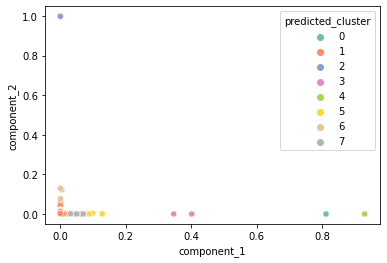

In [18]:
sns.scatterplot(x = pcadf["component_1"], 
                y = pcadf["component_2"], 
                hue = pcadf["predicted_cluster"], 
                palette = "Set2")

### Text Summarization

In [19]:
stopwords = list(STOP_WORDS)
stopwords

['her',
 'through',
 'perhaps',
 'until',
 'which',
 'beside',
 'else',
 'unless',
 'something',
 'whoever',
 'themselves',
 'under',
 'thus',
 'fifty',
 'how',
 '’d',
 'somehow',
 'throughout',
 'five',
 'along',
 'please',
 'before',
 'against',
 'seeming',
 'becomes',
 'via',
 'with',
 'anything',
 'my',
 'onto',
 '‘m',
 'whose',
 'for',
 'although',
 'nothing',
 'was',
 'himself',
 'ca',
 'upon',
 'over',
 'full',
 'since',
 'there',
 'became',
 'must',
 '’s',
 'hereupon',
 'is',
 'yourself',
 'anyhow',
 'the',
 'but',
 'wherein',
 'many',
 'hence',
 'twelve',
 'fifteen',
 'his',
 'been',
 'not',
 'several',
 'beyond',
 'itself',
 'we',
 'yet',
 'most',
 'meanwhile',
 'quite',
 'across',
 'hereafter',
 'indeed',
 'thereupon',
 'really',
 'due',
 'alone',
 'by',
 'becoming',
 'give',
 'might',
 'front',
 'ours',
 'have',
 'herein',
 'seems',
 'very',
 'mine',
 'behind',
 'therein',
 'though',
 'keep',
 'part',
 'somewhere',
 'could',
 'then',
 'often',
 'too',
 'sometime',
 'whole',

In [20]:
nlp = spacy.load('en_core_web_sm')

In [21]:
text = open('C:/Users/811864/Desktop/clean_messages.txt')

string_without_line_breaks = ""
for line in text:
  stripped_line = line.rstrip()
  string_without_line_breaks += stripped_line
text.close()

print(string_without_line_breaks)

 System or agent has recently restarted Interface state changed to operationally downNameEthernet P-C- previous state was up Device Failed Availability CheckUDP - SNMP" VMwareVM CPU Usage Has Exceeded Thresholdcurrently ." Device Failed Availability CheckComponent deviceis not availableNTNX-local-ds-SMJ-B ReasonAvailability App Device Failed Availability CheckComponent deviceis not availableReasonAt least one ancestor of IntegrateStaging IDhas Required service not runningTomcat Device Failed Availability CheckComponent deviceis not availableReasonAt least one ancestor of dataconstructionserver ID System or agent has recently restarted" Host ResourceCPU has exceeded threshold . The current value is .." System or agent has recently restarted" Host ResourceCPU has exceeded threshold . The current value is .."" CiscoBGP Peers ... Peer state is not established and Prior state was established"" devdataulvFile system usage exceeded critical thresholdLimit. Actual."" Device Failed Availability

In [22]:
doc = nlp(string_without_line_breaks)

In [23]:
tokens = [token.text for token in doc]
print(tokens)

[' ', 'System', 'or', 'agent', 'has', 'recently', 'restarted', 'Interface', 'state', 'changed', 'to', 'operationally', 'downNameEthernet', 'P', '-', 'C-', 'previous', 'state', 'was', 'up', 'Device', 'Failed', 'Availability', 'CheckUDP', '-', 'SNMP', '"', 'VMwareVM', 'CPU', 'Usage', 'Has', 'Exceeded', 'Thresholdcurrently', '.', '"', 'Device', 'Failed', 'Availability', 'CheckComponent', 'deviceis', 'not', 'availableNTNX', '-', 'local', '-', 'ds', '-', 'SMJ', '-', 'B', 'ReasonAvailability', 'App', 'Device', 'Failed', 'Availability', 'CheckComponent', 'deviceis', 'not', 'availableReasonAt', 'least', 'one', 'ancestor', 'of', 'IntegrateStaging', 'IDhas', 'Required', 'service', 'not', 'runningTomcat', 'Device', 'Failed', 'Availability', 'CheckComponent', 'deviceis', 'not', 'availableReasonAt', 'least', 'one', 'ancestor', 'of', 'dataconstructionserver', 'ID', 'System', 'or', 'agent', 'has', 'recently', 'restarted', '"', 'Host', 'ResourceCPU', 'has', 'exceeded', 'threshold', '.', 'The', 'curren

In [24]:
punctuation = punctuation + '\n' + '..' + '...'
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\n.....'

In [25]:
word_frequencies = {}
for word in doc:
    if word.text.lower() not in stopwords:
        if word.text.lower() not in punctuation:
            if word.text not in word_frequencies.keys():
                word_frequencies[word.text] = 1
            else:
                word_frequencies[word.text] += 1

In [26]:
print(word_frequencies)

{' ': 1, 'System': 404, 'agent': 363, 'recently': 363, 'restarted': 363, 'Interface': 238, 'state': 460, 'changed': 222, 'operationally': 220, 'downNameEthernet': 25, 'P': 5, 'C-': 1, 'previous': 150, 'Device': 1510, 'Failed': 1284, 'Availability': 1285, 'CheckUDP': 359, 'SNMP': 359, 'VMwareVM': 83, 'CPU': 132, 'Usage': 117, 'Exceeded': 143, 'Thresholdcurrently': 137, 'CheckComponent': 817, 'deviceis': 817, 'availableNTNX': 27, 'local': 28, 'ds': 27, 'SMJ': 3, 'B': 9, 'ReasonAvailability': 249, 'App': 253, 'availableReasonAt': 309, 'ancestor': 309, 'IntegrateStaging': 1, 'IDhas': 198, 'Required': 220, 'service': 272, 'runningTomcat': 157, 'dataconstructionserver': 1, 'ID': 283, 'Host': 262, 'ResourceCPU': 133, 'exceeded': 652, 'threshold': 492, 'current': 243, 'value': 322, 'CiscoBGP': 13, 'Peers': 13, 'Peer': 18, 'established': 30, 'Prior': 15, 'devdataulvFile': 1, 'system': 160, 'usage': 222, 'critical': 185, 'thresholdLimit': 160, 'Actual': 160, 'vaqupapesx.sephoraus.c': 15, 'dswper

In [27]:
max_frequency = max(word_frequencies.values())

In [28]:
max_frequency

1510

In [29]:
for word in word_frequencies.keys():
    word_frequencies[word] = word_frequencies[word]/max_frequency

In [30]:
print(word_frequencies)

{' ': 0.0006622516556291391, 'System': 0.2675496688741722, 'agent': 0.24039735099337747, 'recently': 0.24039735099337747, 'restarted': 0.24039735099337747, 'Interface': 0.1576158940397351, 'state': 0.304635761589404, 'changed': 0.14701986754966886, 'operationally': 0.1456953642384106, 'downNameEthernet': 0.016556291390728478, 'P': 0.0033112582781456954, 'C-': 0.0006622516556291391, 'previous': 0.09933774834437085, 'Device': 1.0, 'Failed': 0.8503311258278146, 'Availability': 0.8509933774834437, 'CheckUDP': 0.23774834437086093, 'SNMP': 0.23774834437086093, 'VMwareVM': 0.05496688741721854, 'CPU': 0.08741721854304636, 'Usage': 0.07748344370860927, 'Exceeded': 0.09470198675496688, 'Thresholdcurrently': 0.09072847682119205, 'CheckComponent': 0.5410596026490067, 'deviceis': 0.5410596026490067, 'availableNTNX': 0.017880794701986755, 'local': 0.018543046357615896, 'ds': 0.017880794701986755, 'SMJ': 0.001986754966887417, 'B': 0.005960264900662252, 'ReasonAvailability': 0.16490066225165562, 'App'

In [31]:
sentence_tokens = [sent for sent in doc.sents]
print(sentence_tokens)

[ System or agent has recently restarted Interface state changed to operationally downNameEthernet P-C- previous state was up Device Failed Availability CheckUDP - SNMP", VMwareVM CPU Usage Has Exceeded Thresholdcurrently .", Device Failed Availability CheckComponent deviceis not availableNTNX-local-ds-SMJ-B ReasonAvailability App Device Failed Availability CheckComponent deviceis not availableReasonAt least one ancestor of IntegrateStaging IDhas Required service not runningTomcat Device Failed Availability CheckComponent deviceis not availableReasonAt least one ancestor of dataconstructionserver ID System or agent has recently restarted" Host ResourceCPU has exceeded threshold ., The current value is .." System or agent has recently restarted" Host ResourceCPU has exceeded threshold ., The current value is .."" CiscoBGP Peers ..., Peer state is not established and Prior state was established"" devdataulvFile system usage exceeded critical thresholdLimit., Actual., "" Device Failed Ava

In [32]:
sentence_scores = {}
for sent in sentence_tokens:
    for word in sent:
        if word.text.lower() in word_frequencies.keys():
            if sent not in sentence_scores.keys():
                sentence_scores[sent] = word_frequencies[word.text.lower()]
            else:
                sentence_scores[sent] += word_frequencies[word.text.lower()]

In [33]:
sentence_scores

{ System or agent has recently restarted Interface state changed to operationally downNameEthernet P-C- previous state was up Device Failed Availability CheckUDP - SNMP": 1.8635761589403972,
 VMwareVM CPU Usage Has Exceeded Thresholdcurrently .": 0.5841059602649006,
 Device Failed Availability CheckComponent deviceis not availableNTNX-local-ds-SMJ-B ReasonAvailability App Device Failed Availability CheckComponent deviceis not availableReasonAt least one ancestor of IntegrateStaging IDhas Required service not runningTomcat Device Failed Availability CheckComponent deviceis not availableReasonAt least one ancestor of dataconstructionserver ID System or agent has recently restarted" Host ResourceCPU has exceeded threshold .: 3.9556291390728484,
 The current value is .." System or agent has recently restarted" Host ResourceCPU has exceeded threshold .: 1.9629139072847681,
 The current value is .."" CiscoBGP Peers ...: 0.3741721854304636,
 Peer state is not established and Prior state was e

In [34]:
select_length = int(len(sentence_tokens)*0.01)
select_length

16

In [35]:
summary = nlargest(select_length, sentence_scores, key = sentence_scores.get)

In [36]:
summary

[Interface state changed to operationally downNameethernet Private previous state was up Device Failed Availability CheckComponent deviceis not available Device Failed Availability CheckComponent deviceis not available Device Failed Availability CheckComponent deviceis not availableVAQUVAPEND ReasonAvailability App ID running on parent DID System or agent has recently restarted Interface state changed to operationally downNameethernet ServicesVLAN previous state was up Device Failed Availability CheckComponent deviceis not availableetm-wo-lun ReasonAvailability App ID running on parent DID Filesystem unavailableCon Device Disk ILogical Physical Percent Disk Time has exceeded threshold currently System or agent has recently restarted Interface state changed to operationally downNameethernet Private VLANprevious state was up Device Failed Availability CheckComponent deviceis not available" VMwareHost Memory Usage Has Exceeded Thresholdcurrently .",
 Device Failed Availability CheckCompon

In [37]:
final_summary = [word.text for word in summary]

In [38]:
summary = ' '.join(final_summary)

In [39]:
print(summary)

Interface state changed to operationally downNameethernet Private previous state was up Device Failed Availability CheckComponent deviceis not available Device Failed Availability CheckComponent deviceis not available Device Failed Availability CheckComponent deviceis not availableVAQUVAPEND ReasonAvailability App ID running on parent DID System or agent has recently restarted Interface state changed to operationally downNameethernet ServicesVLAN previous state was up Device Failed Availability CheckComponent deviceis not availableetm-wo-lun ReasonAvailability App ID running on parent DID Filesystem unavailableCon Device Disk ILogical Physical Percent Disk Time has exceeded threshold currently System or agent has recently restarted Interface state changed to operationally downNameethernet Private VLANprevious state was up Device Failed Availability CheckComponent deviceis not available" VMwareHost Memory Usage Has Exceeded Thresholdcurrently ." Device Failed Availability CheckComponent

In [40]:
len(string_without_line_breaks)

236568

In [41]:
len(summary)

12732